In [43]:
# torch compute all eigenvalues/eigenvectors to solve for fiedler vector

import torch
import torch.nn as nn
import scipy
import numpy as np
import sys
sys.path.append("../")
from ddn.pytorch.node import *
import warnings
warnings.filterwarnings('ignore')

class NormalizedCuts(EqConstDeclarativeNode):
    """
    A declarative node to embed Normalized Cuts into a Neural Network
    
    Normalized Cuts and Image Segmentation https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf
    Shi, J., & Malik, J. (2000)
    """
    def __init__(self):
        super().__init__()
        
    def objective(self, x, y):
        # x is an NxN symmetrical matrix with W(i,j) = w_ij
        D = x.sum(0).diag() # D is an NxN diagonal matrix with d on diagonal, for d(i) = sum_j(w(i,j))
        ONE = torch.ones(x.size(dim=0),1)   # Nx1 vector of all ones
        L = D - x
        
        # L_sym = torch.mm(torch.mm(torch.diag(torch.pow(torch.diag(D),-0.5)),L),torch.diag(torch.pow(torch.diag(D),-0.5)))
        return torch.mm(torch.mm(torch.t(y),L), y)
    
    def equality_constraints(self, x, y):
        """
        subject to y^T 1 = 0
        """
        ONE = torch.ones(x.size(dim=0),1)
        return torch.mm(torch.t(y),ONE)

    def solve(self, x):
        D = x.sum(0).diag() # D is an NxN diagonal matrix with d on diagonal, for d(i) = sum_j(w(i,j))
        ONE = torch.ones(x.size(dim=0),1)   # Nx1 vector of all ones
        L = D - x
        
        val, vec = torch.linalg.eigh(L)
        seen = {}
        uniques = []
        for (x,y) in zip(val, vec):
            if x in seen:
                continue
            seen[x] = 1
            uniques.append((x,y))
        fiedler = sorted(uniques)[1][1]
        return fiedler, _
    
torch.set_default_tensor_type(torch.DoubleTensor)

node = NormalizedCuts()
x = torch.tensor([[0,1,0,0], [1,0,0,3], [0,0,0,0], [0,3,0,0]]).double()
print(x)
y,_ = node.solve(x)
node.gradient(x, y=y)
print(y)
print("done")
# torch.cuda.set_device(gpu)
# model = model.cuda(gpu)

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 3.],
        [0., 0., 0., 0.],
        [0., 3., 0., 0.]])


RuntimeError: self must be a matrix

In [12]:
# The constituent components of a U-Net model
#############################################
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
# A normal UNet model
#########################
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
# Combination of everything
###########################
class Net(nn.Module):
    def __init__(self):
        """
        instatiate parameter
        """
        super().__init__()
    
# GPU ID to use
gpu = 1

# Create model, set to use GPU
model = Net()

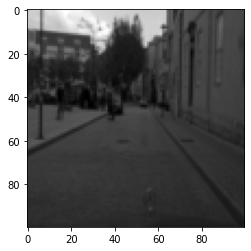

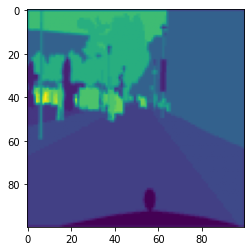

In [40]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from torchvision import transforms, datasets
import matplotlib.pyplot as plt


# https://github.com/pytorch/vision/issues/2212#issuecomment-944225785
# Compose and StandardCompose don't work together nicely? might not be an issue
class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            self.PIL2Numpy = True

        for a in self.augmentations:
            img = a(img)

        if self.PIL2Numpy:
            img = np.array(img)

        return img

data_transform = Compose([
    transforms.Resize(size=(100,100)),
    transforms.Grayscale(1),
    transforms.ToTensor()
    ])

target_transform = Compose([
    transforms.Resize(size=(100,100)),
    transforms.ToTensor()
    ])
    
train_city = torchvision.datasets.Cityscapes(root='./data/cityscapes/', split='train', mode='fine',
                     target_type='semantic', transform=data_transform, target_transform=target_transform)

test_city = torchvision.datasets.Cityscapes(root='./data/cityscapes/', split='test', mode='fine',
                     target_type='semantic', transform=data_transform, target_transform=target_transform)

# visualise
img, smnt = train_city[0]
plt.imshow(img[0], cmap='gray')
plt.show()
plt.imshow(smnt[0])
plt.show()